In [1]:
## Covid_19 Swiss Data Analysi

In [253]:
#Step
import math
from scipy import stats
import pandas as pd
from datetime import date, datetime
pd.plotting.register_matplotlib_converters()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.optimize import curve_fit
sns.set(style="ticks")
sns.set_context("talk")

print("Setup Complete")
data = pd.read_csv("https://raw.githubusercontent.com/daenuprobst/covid19-cases-switzerland/master/covid19_cases_switzerland.csv")

Setup Complete


In [254]:

#Load Data
path = ('/home/micatske/covid-analysis/COVID19_Fallzahlen_CH_total_v2.csv')
 
df_swiss = pd.read_csv(path, parse_dates=True)
df_swiss.shape
df_swiss=df_swiss.drop(['time','source'],axis=1)
df_swiss.head()
df_swiss=df_swiss.rename(columns={'abbreviation_canton_and_fl':'cantons'})
df_swiss.head()
data.head()

,Date,AG,AI,AR,BE,BL,BS,FR,GE,GL,...,SO,SZ,TG,TI,UR,VD,VS,ZG,ZH,CH
0,2020-03-06,10.0,0.0,1.0,20.0,9.0,17.0,7.0,17.0,0.0,...,1.0,7.0,1.0,37.0,0.0,23.0,4.0,5.0,24.0,208
1,2020-03-07,14.0,0.0,1.0,25.0,13.0,22.0,7.0,26.0,0.0,...,1.0,7.0,1.0,43.0,0.0,30.0,5.0,6.0,28.0,263
2,2020-03-08,14.0,0.0,1.0,31.0,19.0,25.0,8.0,35.0,0.0,...,1.0,7.0,1.0,58.0,0.0,40.0,5.0,7.0,34.0,328
3,2020-03-09,14.0,0.0,2.0,34.0,20.0,29.0,10.0,44.0,0.0,...,1.0,7.0,2.0,67.0,0.0,51.0,7.0,7.0,36.0,376
4,2020-03-10,15.0,0.0,2.0,39.0,22.0,39.0,12.0,68.0,0.0,...,1.0,7.0,3.0,91.0,0.0,77.0,15.0,7.0,45.0,505


In [255]:
#Cleaning Data, check missing Values
df_swiss.isnull().sum()

date                                      0
cantons                                   0
ncumul_tested                         14378
ncumul_conf                             287
new_hosp                              13684
current_hosp                           2473
current_icu                            4249
current_vent                          10035
ncumul_released                        9459
ncumul_deceased                         941
current_isolated                       8134
current_quarantined                    8231
current_quarantined_riskareatravel    10742
current_quarantined_total             14617
dtype: int64

In [257]:


#For missing ncumul_*,current_*, we fill NaN forward and with 0.
col_ncumul=['ncumul_tested','ncumul_conf','ncumul_released','ncumul_deceased']
#df_swiss[col_ncumul]=df_swiss[col_ncumul].fillna(method='ffill').fillna(0)
#For missing  we fill NaN with 0
#col_current=['current_hosp','current_icu','current_vent','current_isolated','current_quarantined','current_quarantined_riskareatravel','current_quarantined_total']
#df_swiss[col_current]=df_swiss[col_current].fillna(method='ffill').fillna(0)
#For missing new_hosp, we fill NAN with 0
df_swiss['new_hosp']=df_swiss['new_hosp'].fillna(0)
df_swiss=df_swiss.fillna(0)
df_swiss.head()
df_swiss.tail()

,date,cantons,ncumul_tested,ncumul_conf,new_hosp,current_hosp,current_icu,current_vent,ncumul_released,ncumul_deceased,current_isolated,current_quarantined,current_quarantined_riskareatravel,current_quarantined_total
14612,2021-10-05,SZ,0.0,15556.0,0.0,0.0,0.0,0.0,14859.0,249.0,0.0,0.0,0.0,0.0
14613,2021-10-05,TG,0.0,25117.0,0.0,24.0,10.0,0.0,1426.0,486.0,0.0,0.0,0.0,0.0
14614,2021-10-05,BS,0.0,16186.0,0.0,16.0,6.0,0.0,15801.0,213.0,172.0,127.0,0.0,0.0
14615,2021-10-05,AI,0.0,1735.0,0.0,0.0,0.0,0.0,0.0,17.0,13.0,7.0,0.0,0.0
14616,2021-10-05,ZH,0.0,139938.0,0.0,99.0,46.0,32.0,0.0,1481.0,1516.0,6450.0,0.0,0.0


In [258]:
df_swiss.isnull().sum()

date                                  0
cantons                               0
ncumul_tested                         0
ncumul_conf                           0
new_hosp                              0
current_hosp                          0
current_icu                           0
current_vent                          0
ncumul_released                       0
ncumul_deceased                       0
current_isolated                      0
current_quarantined                   0
current_quarantined_riskareatravel    0
current_quarantined_total             0
dtype: int64

In [259]:
#Prepoccessing Data, we split the data to testing, hospital and quarantine
cantons=df_swiss.cantons.unique()
print(cantons)
col_cases=['date','cantons','ncumul_tested','ncumul_conf']
col_hos=['date','cantons','new_hosp','current_hosp','current_icu','current_vent','ncumul_released','ncumul_deceased']
col_qua=['date','cantons','current_quarantined','current_quarantined_riskareatravel','current_quarantined_total']
#swiss_canton=df_swiss.groupby('abbreviation_canton_and_fl')
df_cases=df_swiss[col_cases]
df_hos=df_swiss[col_hos]
df_qua=df_swiss[col_qua]

['GE' 'BL' 'TI' 'GR' 'AG' 'BE' 'FL' 'JU' 'LU' 'ZH' 'BS' 'VD' 'VS' 'FR'
 'ZG' 'NE' 'SG' 'SZ' 'AR' 'TG' 'SO' 'GL' 'NW' 'SH' 'UR' 'OW' 'AI']


# Visualization

In [267]:
#Visualization of Total Case
df_cases['CH']=
for canton in cantons:
    total = df_cases['date'].ncumul_tested

In [227]:
#Canton Testing
df_cases_cantons=df_cases.groupby(['cantons','date'])
df_cases_cantons.head()

,cantons,ncumul_tested,ncumul_conf
date,,,
2020-01-01,GE,0.0,1.0
2020-01-02,GE,0.0,1.0
2020-01-03,GE,0.0,1.0
2020-01-04,GE,0.0,1.0
2020-01-05,GE,0.0,5.0
...,...,...,...
2021-10-05,SZ,45004.0,15556.0
2021-10-05,TG,45004.0,25117.0
2021-10-05,BS,45004.0,16186.0


In [224]:
#Canton Confirmed
print(df_cases.groupby('cantons').ncumul_conf.agg([len, min, max]).sort_values(by='min', ascending=False))

         len  min       max
cantons                    
NW       573  4.0    3290.0
ZH       587  2.0  139938.0
AI       361  2.0    1735.0
UR       386  2.0    4296.0
GR       587  2.0   16605.0
VS       585  1.0   42712.0
VD       501  1.0   95606.0
TG       580  1.0   25117.0
SZ       565  1.0   15556.0
SO       405  1.0   39281.0
SH       573  1.0    6195.0
SG       582  1.0   54004.0
OW       475  1.0    3539.0
AG       587  1.0   59420.0
LU       572  1.0   36785.0
JU       586  1.0    8229.0
GL       544  1.0   36629.0
GE       644  1.0   67290.0
BS       587  1.0   16186.0
BE       583  1.0   80270.0
AR       300  1.0  138687.0
NE       583  1.0   19708.0
FR       583  0.0   36629.0
FL       584  0.0    3451.0
TI       530  0.0   36124.0
BL       589  0.0   22842.0
ZG       585  0.0   10443.0


<AxesSubplot:title={'center':'Vaud Tested and Confirmed'}, xlabel='date'>

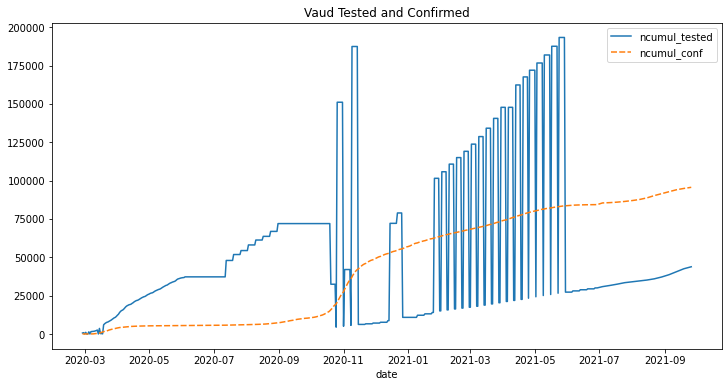

In [228]:
#Vaud Analysis
df_cases_vd=df_cases.loc[(df_cases.cantons == 'VD')]
plt.figure(figsize=(12,6))
plt.title('Vaud Tested and Confirmed')
sns.lineplot(data=df_cases_vd)